In [29]:
import cv2
import torch
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits import mplot3d
import plotly.graph_objects as go

In [30]:
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/pierreadorni/.cache/torch/hub/intel-isl_MiDaS_master
/Users/pierreadorni/Documents/depth-estimation/venv/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning:

Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.



In [31]:
device = torch.device("cpu")
midas.to(device)

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

In [32]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

Using cache found in /Users/pierreadorni/.cache/torch/hub/intel-isl_MiDaS_master


In [33]:
cam = cv2.VideoCapture(0)
time.sleep(1)
_, img = cam.read()
# close video cap
cam.release()

In [34]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(-0.5, 1919.5, 1079.5, -0.5)

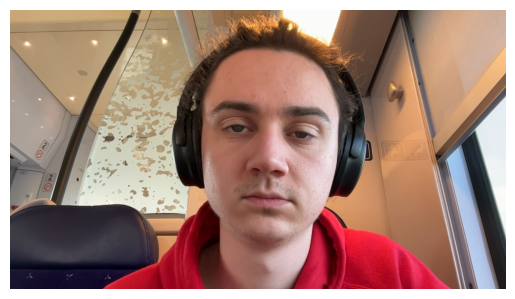

In [35]:
plt.imshow(img)
plt.axis("off")

In [36]:
# get depth
input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bilinear",
            align_corners=False,
        ).squeeze()

(-0.5, 1919.5, 1079.5, -0.5)

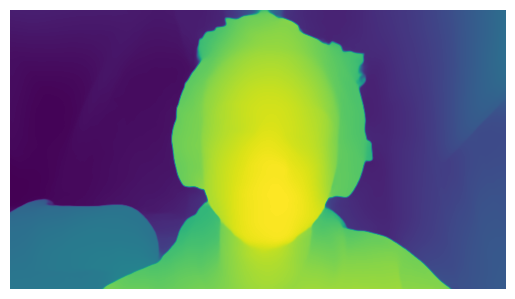

In [37]:
output = prediction.cpu().numpy()
plt.imshow(output)
plt.axis('off')

In [38]:
# now use YOLO to get a mask of the person
from ultralytics import YOLO

In [39]:
segv8 = YOLO('yolov8n-seg.pt')


0: 384x640 1 person, 1 umbrella, 1 chair, 66.9ms
Speed: 2.3ms preprocess, 66.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


(-0.5, 1919.5, 1079.5, -0.5)

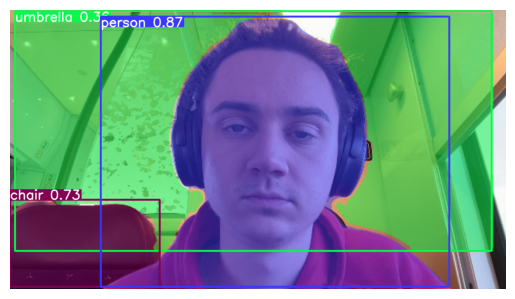

In [40]:
seg = segv8(img)
seg_plotted = seg[0].plot()
plt.imshow(seg_plotted)
plt.axis("off")

In [41]:
# extract the mask of the person
seg[0].masks.data[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [42]:
seg[0].boxes.cls

tensor([ 0., 56., 25.])

In [43]:
# find in the boxes the index of the box with class 0 (person)
person_idx = np.where(seg[0].boxes.cls == 0)[0][0]
# get the corresponding mask
person_mask = np.array(seg[0].masks.data[person_idx])

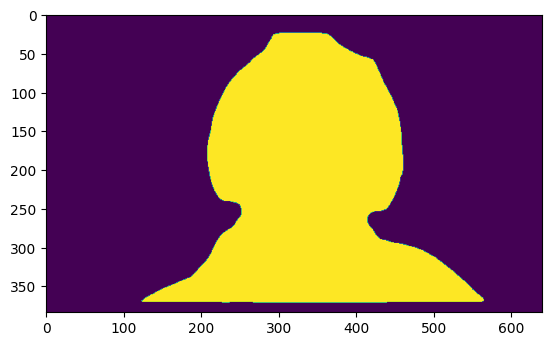

In [44]:
plt.imshow(person_mask)

In [45]:
# resize the mask to the size of the depth image
person_mask = cv2.resize(person_mask, (output.shape[1], output.shape[0])).astype(np.uint8)

In [46]:
# now apply the mask to the depth image and init image
masked_depth = output * person_mask
masked_img = (img * person_mask[:, :, np.newaxis]).astype(np.uint8)

(-0.5, 1919.5, 1079.5, -0.5)

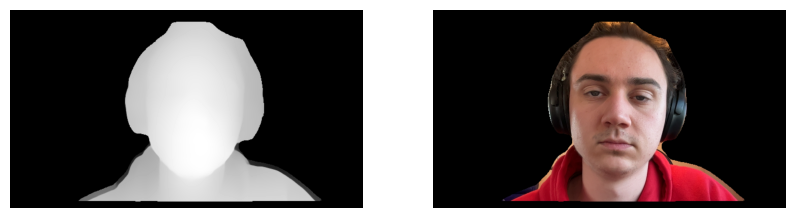

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(masked_depth, cmap='gray')
ax[0].axis('off')
ax[1].imshow(masked_img)
ax[1].axis('off')

In [48]:
# now we construct the 3d point cloud with depth and color
# downsize depth image by 10 for fast plotting
person_mask = cv2.resize(person_mask, (int(person_mask.shape[1]/10), int(person_mask.shape[0]/10))).astype(np.uint8)
output = cv2.resize(output, (int(output.shape[1]/10), int(output.shape[0]/10)))
img = cv2.resize(img, (int(img.shape[1]/10), int(img.shape[0]/10)))

In [49]:
output.shape

(108, 192)

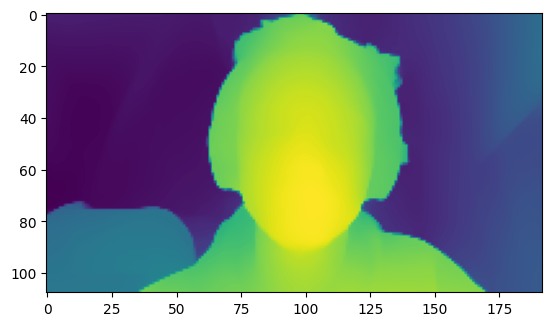

In [50]:
plt.imshow(output)

In [51]:
# now we show the 3d point cloud using plotl
xx, yy = np.meshgrid(np.arange(person_mask.shape[1]), np.arange(person_mask.shape[0]))
xx = xx[person_mask == 1]
yy = yy[person_mask == 1]
zz = output[person_mask == 1]

marker_data = go.Scatter3d(
    x=xx.flatten(),
    y=yy.flatten(),
    z=zz.flatten(),
    marker=go.scatter3d.Marker(size=3),
    mode='markers',
    marker_color=img[person_mask == 1].reshape(-1, 3) / 255
)
fig=go.Figure(data=marker_data)
fig.show()